In [1]:
# Auxiliaries (Importing Datafile, Checking Time)
import os 
import time

# Calculations
import numpy as np

# For Importing Data Files
import pandas as pd
import glob

# For Data Visualization
import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np
from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu
from skimage import color

# For Image Pre-Processing
import cv2

# Create dataframe

3 columns
1. Disease Classification
2. Image Name
3. Image RGB Values (RGB Converted from BGR)

In [2]:
def natural_sort_key(s):
    """Key function for natural sorting."""
    import re
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def create_dataframe_from_folders(root_folder):
    # Initialize empty lists to store data for each column
    folder_names = []
    photo_names = []
    photos = []

    # Traverse through the root folder and its subfolders
    for folder_name in sorted(os.listdir(root_folder)):
        folder_path = os.path.join(root_folder, folder_name)

        # Check if the entry in the root folder is a directory
        if os.path.isdir(folder_path):
            for photo_name in sorted(os.listdir(folder_path), key=natural_sort_key):
                # Assuming photos are in common image formats (e.g., jpg, png)
                if photo_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    photo_path = os.path.join(folder_path, photo_name)

                    # Read image data using cv2
                    image_data = cv2.imread(photo_path)

                    # Convert BGR to RGB
                    image_data_rgb = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

                    # Append data to the lists
                    folder_names.append(folder_name)
                    photo_names.append(photo_name)
                    photos.append(image_data_rgb)

    # Create a DataFrame
    df = pd.DataFrame({
        'class': folder_names,
        'img_name': photo_names,
        'rgb': photos
    })

    return df

Get data frame 

In [3]:
# Example usage:
extra_resized_folder_path = r"C:\Users\Josh\000 Files\003 Mengg AI\01a 201 (AI)\03 Mini-Project\resized_raw_images (3 Classes - Zoomed)"
extra_resized = create_dataframe_from_folders(extra_resized_folder_path)

# Display the resulting DataFrame
print(extra_resized.head())

                   class            img_name  \
0  bacterial_leaf_blight  BLB_single (1).jpg   
1  bacterial_leaf_blight  BLB_single (2).jpg   
2  bacterial_leaf_blight  BLB_single (3).jpg   
3  bacterial_leaf_blight  BLB_single (4).jpg   
4  bacterial_leaf_blight  BLB_single (5).jpg   

                                                 rgb  
0  [[[161, 125, 67], [163, 128, 70], [166, 132, 7...  
1  [[[238, 229, 222], [238, 229, 222], [238, 229,...  
2  [[[236, 225, 219], [237, 226, 220], [238, 227,...  
3  [[[236, 223, 217], [236, 223, 217], [237, 224,...  
4  [[[236, 225, 221], [236, 225, 221], [236, 225,...  


**Class Counts**

In [4]:
class_counts = extra_resized['class'].value_counts()

print(class_counts)

class
brown_spot               54
rice_blast               50
bacterial_leaf_blight    48
Name: count, dtype: int64


# Feature Extraction

## Texture Features

In [5]:
import pandas as pd
import numpy as np
import mahotas
from itertools import product
import time

def compute_glcm_features(df):
    df['gray'] = df['rgb'].apply(lambda x: cv2.cvtColor(np.uint8(x), cv2.COLOR_RGB2GRAY))
    def calculate_glcm(gray_image):
        # Compute GLCM using mahotas
        glcm = mahotas.features.haralick(gray_image.astype(np.uint8), ignore_zeros=True)
        return glcm.mean(axis=0)

    features = []

    start_time = time.time()
    
    for index, row in df.iterrows():
        gray_image = row['gray']
        glcm_features = calculate_glcm(gray_image)
        features.append(glcm_features)

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Define meaningful column names for GLCM features
    glcm_columns = [
        'Angular Second Moment',
        'Contrast',
        'Correlation',
        'Sum of Squares: Variance',
        'Inverse Difference Moment',
        'Sum Average',
        'Sum Variance',
        'Sum Entropy',
        'Entropy',
        'Difference Variance',
        'Difference Entropy',
        'Informational Measure of Correlation 1',
        'Informational Measure of Correlation 2'
    ]

    # Create a DataFrame with the new GLCM features and meaningful column names
    glcm_df = pd.DataFrame(features, columns=[f'GLCM_{col}' for col in glcm_columns])

    # Concatenate the new DataFrame with the original DataFrame
    result_df = pd.concat([df, glcm_df], axis=1)

    print(f"Elapsed Time: {elapsed_time:.2f} seconds")

    return result_df

In [6]:
glcm = compute_glcm_features(extra_resized)

Elapsed Time: 2.50 seconds


In [7]:
# Remove the first n columns
f_glcm = glcm.iloc[:, 4:]

In [8]:
f_glcm.head()

,GLCM_Angular Second Moment,GLCM_Contrast,GLCM_Correlation,GLCM_Sum of Squares: Variance,GLCM_Inverse Difference Moment,GLCM_Sum Average,GLCM_Sum Variance,GLCM_Sum Entropy,GLCM_Entropy,GLCM_Difference Variance,GLCM_Difference Entropy,GLCM_Informational Measure of Correlation 1,GLCM_Informational Measure of Correlation 2
0,0.000358,266.001841,0.964868,3785.238579,0.239492,180.814209,14874.952473,8.629918,12.466566,0.000331,4.343470,-0.369462,0.997668
1,0.018832,29.540256,0.994057,2484.910874,0.515623,370.827844,9910.103241,6.141836,8.088455,0.000993,2.749243,-0.444118,0.993843
2,0.012217,47.934937,0.991704,2888.983700,0.439836,355.884272,11507.999864,6.346219,8.658163,0.000813,3.050238,-0.405166,0.991940
3,0.019039,56.672401,0.992339,3697.472233,0.519511,348.227408,14733.216531,6.472970,8.465276,0.000997,2.890223,-0.465543,0.996049
4,0.025665,45.344059,0.993331,3397.524613,0.590942,379.393294,13544.754392,5.682043,7.201895,0.001234,2.390516,-0.478429,0.993598


## Histogram Features

In [9]:
import cv2
import numpy as np
from skimage import color
from sklearn.preprocessing import normalize

In [10]:
def values(dataframe):
    # Ensure the 'rgb' column exists in the dataframe
    dataframe['hsv'] = dataframe['rgb'].apply(lambda x: cv2.cvtColor(np.uint8(x), cv2.COLOR_RGB2HSV))
    #dataframe['hsi'] = dataframe['rgb'].apply(lambda x: color.rgb2hsi(np.uint8(x)))
    dataframe['lab'] = dataframe['rgb'].apply(lambda x: cv2.cvtColor(np.uint8(x), cv2.COLOR_RGB2LAB))

    dataframe['red'] = dataframe['rgb'].apply(lambda rgb: rgb[:,:,0])
    dataframe['green'] = dataframe['rgb'].apply(lambda rgb: rgb[:,:,1])
    dataframe['blue'] = dataframe['rgb'].apply(lambda rgb: rgb[:,:,2])
    
    dataframe['hue_v'] = dataframe['hsv'].apply(lambda hsv: hsv[:,:,0])
    dataframe['saturation_v'] = dataframe['hsv'].apply(lambda hsv: hsv[:,:,1])
    dataframe['value_v'] = dataframe['hsv'].apply(lambda hsv: hsv[:,:,2])
    
    #dataframe['hue_i'] = dataframe['hsv'].apply(lambda hsi: hsi[:,:,0])
    #dataframe['saturation_i'] = dataframe['hsv'].apply(lambda hsi: hsi[:,:,1])
    #dataframe['intensity_i'] = dataframe['hsv'].apply(lambda hsi: hsi[:,:,2])
    
    dataframe['lightness'] = dataframe['lab'].apply(lambda lab: lab[:, :, 0])
    dataframe['a'] = dataframe['lab'].apply(lambda lab: lab[:, :, 1])
    dataframe['b'] = dataframe['lab'].apply(lambda lab: lab[:, :, 2])

    return dataframe

In [11]:
import pandas as pd
import numpy as np

def add_bins_to_dataframe(dataframe, column_name, num_bins):
    # Extract the specified column
    original_column = dataframe[column_name]

    # Define bin edges based on the min and max values in the matrices
    min_value = np.min([np.min(matrix) for matrix in original_column])
    max_value = np.max([np.max(matrix) for matrix in original_column])

    bin_edges = np.linspace(min_value, max_value, num_bins + 1)

    # Create column names for the bins
    bin_column_names = [f'{column_name}_{i}' for i in range(num_bins)]

    # Iterate through each matrix in the original column
    for i, matrix in enumerate(original_column):
        # Digitize each element in the matrix into the corresponding bin
        bin_indices = np.digitize(matrix.flatten(), bin_edges, right=True)

        # Count the occurrences of each bin index
        bin_counts = np.bincount(bin_indices, minlength=num_bins + 1)[1:]

        # Add new columns to the DataFrame for each bin
        for j, bin_column_name in enumerate(bin_column_names):
            dataframe.loc[i, bin_column_name] = bin_counts[j]

    return dataframe

In [12]:
channels = values(extra_resized)

In [13]:
import pandas as pd
import numpy as np

def create_bins_dataframe(dataframe, col, num_bins):
    bins_dataframe = pd.DataFrame()

    #print(col)
    min_value = np.min([np.min(matrix) for matrix in dataframe[col]])
    max_value = np.max([np.max(matrix) for matrix in dataframe[col]])

    bin_edges = np.linspace(min_value, max_value, num_bins + 1)
    bin_column_names = [f'{col}_{i}' for i in range(1, num_bins + 1)]

    for matrix in dataframe[col]:
        bin_indices = np.digitize(matrix.flatten(), bin_edges, right=True)
        bin_counts = np.bincount(bin_indices, minlength=num_bins + 1)[1:]

        bins_dataframe = pd.concat([bins_dataframe, pd.DataFrame(bin_counts).transpose()], axis=0, ignore_index=True)

    bins_dataframe.columns = bin_column_names
        
    return bins_dataframe

def hist_features(df, cols, bins):
    complete_bins = pd.DataFrame()

    for col in cols:
        col_bins = create_bins_dataframe(df, col, bins)
        complete_bins = pd.concat([complete_bins, col_bins], axis=1)

    return complete_bins

cols = ['red', 'green', 'blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b']

In [14]:
# Assuming 'channels' is your DataFrame
f_histogram = hist_features(channels, cols, 82)

In [15]:
f_histogram.head()

,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,red_10,...,b_73,b_74,b_75,b_76,b_77,b_78,b_79,b_80,b_81,b_82
0,175,390,373,484,879,1088,1006,1012,832,1121,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Color Moments Features

In [16]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import cv2

def color_moments(dataframe, cols):
    for col in cols:
        print(col)
        mean_values = []
        variance_values = []
        kurtosis_values = []
        skewness_values = []

        for img in dataframe[col]:
            # Assuming 'img' is a 3D numpy array representing an RGB image
            # Calculate statistics for each image
            mean_channel = np.mean(img, axis=(0, 1))
            variance_channel = np.var(img, axis=(0, 1))
            kurtosis_channel = kurtosis(img, axis=(0, 1))
            skewness_channel = skew(img, axis=(0, 1))

            # Append values to respective lists
            mean_values.append(mean_channel)
            variance_values.append(variance_channel)
            kurtosis_values.append(kurtosis_channel)
            skewness_values.append(skewness_channel)

        # Add the new columns to the DataFrame with channel names
        for i in range(img.shape[2]):  # Assuming 'img' has shape (height, width, channels)
            dataframe[f'{col}_channel_{i}_mean'] = [x[i] for x in mean_values]
            dataframe[f'{col}_channel_{i}_variance'] = [x[i] for x in variance_values]
            dataframe[f'{col}_channel_{i}_kurtosis'] = [x[i] for x in kurtosis_values]
            dataframe[f'{col}_channel_{i}_skewness'] = [x[i] for x in skewness_values]
    
    return dataframe

In [17]:
color_df = color_moments(extra_resized, ['rgb','hsv','lab'])

rgb
hsv
lab


In [18]:
f_color = color_df.drop(columns=['class','img_name','rgb','gray','hsv','lab','red','green','blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b'])

In [19]:
f_color.head()

,rgb_channel_0_mean,rgb_channel_0_variance,rgb_channel_0_kurtosis,rgb_channel_0_skewness,rgb_channel_1_mean,rgb_channel_1_variance,rgb_channel_1_kurtosis,rgb_channel_1_skewness,rgb_channel_2_mean,rgb_channel_2_variance,...,lab_channel_0_kurtosis,lab_channel_0_skewness,lab_channel_1_mean,lab_channel_1_variance,lab_channel_1_kurtosis,lab_channel_1_skewness,lab_channel_2_mean,lab_channel_2_variance,lab_channel_2_kurtosis,lab_channel_2_skewness
0,96.270089,3990.031165,-0.411904,0.744936,91.700953,3810.139266,-0.052213,0.715675,66.826531,4130.342437,...,-0.306373,0.581436,125.893136,75.606086,1.887396,0.218237,142.877770,139.253973,-0.707640,0.418429
1,199.242566,2069.785490,-1.514378,-0.515288,187.317861,2008.205226,-1.781474,-0.309983,139.516861,7895.016537,...,-1.728330,-0.350443,126.572007,37.250356,-0.824629,-0.589908,153.407805,516.292401,-1.853678,0.254570
2,186.096600,3007.509502,-1.814930,-0.218978,182.329321,2194.281216,-1.800756,-0.187194,135.049247,7673.218019,...,-1.818788,-0.189757,122.807617,76.436941,-1.666075,-0.225414,152.541653,431.494438,-1.912749,0.151626
3,183.299904,3966.247111,-1.576733,-0.496616,176.301718,3005.669150,-1.622519,-0.438570,139.876574,7783.860065,...,-1.594524,-0.460021,125.340880,60.401777,-0.872360,-0.856840,147.570592,328.878308,-1.485259,0.609684
4,195.866789,3836.636711,-1.119386,-0.906572,191.531848,2688.568262,-1.122789,-0.898519,164.997409,6832.874435,...,-1.123964,-0.901373,125.377272,71.134292,-0.437482,-1.166782,142.234515,262.144242,-0.463300,1.184542


## Zernike Features

In [20]:
import cv2
import mahotas.features
import numpy as np
import pandas as pd

def zernike(df, zernike_order):
    features_list = []

    for idx, row in df.iterrows():
        gray_img = row['gray']

        # Check if the image is grayscale
        if len(gray_img.shape) == 2:
            # If grayscale, compute Zernike moments directly
            moments = mahotas.features.zernike_moments(gray_img, radius=zernike_order)
        else:
            raise ValueError("Input image must be grayscale.")

        features_list.append(moments)

    # Determine the number of features per image
    num_features_per_image = len(features_list[0])

    # Add features to the DataFrame
    feature_columns = [f'feature_{i}' for i in range(num_features_per_image)]
    df_features = pd.DataFrame(features_list, columns=feature_columns)
    df_result = pd.concat([df, df_features], axis=1)

    return df_result

In [21]:
zernike_df = zernike(extra_resized, 10)
f_zernike = zernike_df.iloc[:, 51:]
f_zernike.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,0.31831,0.015994,0.005830,0.004560,0.010091,0.015493,0.014889,0.002006,0.005715,0.019349,...,0.002224,0.019971,0.032080,0.029382,0.009788,0.019124,0.006777,0.016389,0.011934,0.013850
1,0.31831,0.001594,0.004247,0.003555,0.011316,0.010798,0.020522,0.017677,0.027740,0.014565,...,0.024135,0.019143,0.020336,0.016388,0.015845,0.003558,0.002029,0.007313,0.008196,0.024526
2,0.31831,0.005007,0.008705,0.006788,0.019123,0.016181,0.003956,0.002548,0.003154,0.013875,...,0.007416,0.025023,0.029394,0.028356,0.004316,0.020854,0.006702,0.015855,0.013115,0.013213
3,0.31831,0.015932,0.063308,0.051655,0.003087,0.017435,0.015274,0.036561,0.007757,0.015761,...,0.001233,0.033839,0.026412,0.008598,0.007508,0.004111,0.003043,0.041183,0.010187,0.023167
4,0.31831,0.003166,0.010777,0.007619,0.004912,0.010917,0.014197,0.007375,0.009341,0.004156,...,0.002502,0.008668,0.026115,0.033828,0.006642,0.002440,0.006141,0.001619,0.005364,0.005747


## Legendre Moments

In [22]:
#extra_resized.head()

In [23]:
l_input = extra_resized.drop(columns=['class','hsv','lab','red','green','blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b'])
l_input = l_input.iloc[:, :4]

In [24]:
l_input.head()

,img_name,rgb,gray,rgb_channel_0_mean
0,BLB_single (1).jpg,"[[[161, 125, 67], [163, 128, 70], [166, 132, 7...","[[129, 132, 135, 136, 136, 138, 139, 139, 137,...",96.270089
1,BLB_single (2).jpg,"[[[238, 229, 222], [238, 229, 222], [238, 229,...","[[231, 231, 231, 231, 230, 229, 230, 230, 229,...",199.242566
2,BLB_single (3).jpg,"[[[236, 225, 219], [237, 226, 220], [238, 227,...","[[228, 229, 230, 231, 231, 231, 230, 229, 230,...",186.096600
3,BLB_single (4).jpg,"[[[236, 223, 217], [236, 223, 217], [237, 224,...","[[226, 226, 227, 227, 227, 227, 227, 227, 227,...",183.299904
4,BLB_single (5).jpg,"[[[236, 225, 221], [236, 225, 221], [236, 225,...","[[228, 228, 228, 228, 228, 228, 228, 228, 228,...",195.866789


In [25]:
import numpy as np
import pandas as pd
import cv2
from scipy.special import legendre

def compute_legendre_features(rgb_image, degree):
    # Get V channel from RGB image
    v_channel = rgb_image[:, :, 2]

    # Define x and y coordinates
    x_size, y_size = v_channel.shape
    x = np.linspace(-1, 1, x_size)
    y = np.linspace(-1, 1, y_size)

    # Compute Legendre features for the V channel
    legendre_features = np.zeros((degree + 1, degree + 1))

    for j in range(degree + 1):
        for k in range(degree + 1):
            legendre_features[j, k] = np.sum(v_channel * legendre(j)(x) * legendre(k)(y))

    return legendre_features.flatten()

def add_legendre(df, degree):
    # Create a new DataFrame for Legendre features
    legendre_columns = [f'v_legendre_{i}_{j}' for i in range(degree + 1) for j in range(degree + 1)]
    legendre_df = pd.DataFrame(df['rgb'].apply(lambda rgb: compute_legendre_features(rgb, degree)).values.tolist(), columns=legendre_columns)

    # Concatenate the new DataFrame with the original DataFrame
    result_df = pd.concat([df, legendre_df], axis=1)

    return result_df

In [26]:
legendre_df = add_legendre(l_input, 10)

In [27]:
f_legendre = legendre_df.iloc[:, 4:]
f_legendre.head()

,v_legendre_0_0,v_legendre_0_1,v_legendre_0_2,v_legendre_0_3,v_legendre_0_4,v_legendre_0_5,v_legendre_0_6,v_legendre_0_7,v_legendre_0_8,v_legendre_0_9,...,v_legendre_10_1,v_legendre_10_2,v_legendre_10_3,v_legendre_10_4,v_legendre_10_5,v_legendre_10_6,v_legendre_10_7,v_legendre_10_8,v_legendre_10_9,v_legendre_10_10
0,3353088.0,-1.087238e+06,235099.508778,138969.614640,-213880.081800,32868.044026,41100.147021,-22057.604276,4093.363361,4959.005446,...,-6311.718764,17134.386705,-4354.325125,21434.136965,-4999.513654,-16770.059701,9646.856903,18634.297732,-77270.510962,171556.758187
1,7000398.0,-1.647153e+05,16993.528324,1784.367334,35445.715279,-2965.453418,31875.111977,-940.235712,29365.092505,-4259.342104,...,-3207.796386,32476.086937,-2489.962161,33577.290543,-2410.030008,34908.447337,-1957.168143,33858.993532,-14522.080791,367208.435549
2,6776231.0,-4.040194e+04,94178.452151,-28337.376132,38294.200615,2442.323361,29519.886739,573.809983,32319.438140,-2597.708766,...,-2207.567426,34574.201478,-962.117115,34265.410875,-840.786748,35865.336257,-4235.821516,42533.736921,-5801.509097,361853.335579
3,7018447.0,9.445593e+04,6862.907016,4972.047285,39488.004341,2049.562175,27225.615815,-3893.297024,36188.794809,4373.071135,...,3169.501812,34547.292349,401.307337,33508.846870,1111.812538,35333.013038,1912.006198,33394.064995,8572.133821,367697.941762
4,8278910.0,-7.859323e+04,13974.904824,924.369355,43248.444176,-1325.024786,36822.544836,-309.008812,39155.165133,-2002.215996,...,-1352.400608,40153.183075,-1015.441145,40220.085810,-1162.845594,41754.143653,-913.967013,39824.164348,-6934.850970,434175.385973


## Complete Features

In [28]:
# Create a new DataFrame with just the selected column
classes = pd.DataFrame(extra_resized['class'])

In [29]:
#complete_features = pd.concat([classes,f_color,f_histogram, f_glcm], axis=1)
complete_features = pd.concat([classes,f_histogram, f_glcm, f_color, f_legendre, f_zernike], axis=1)

In [30]:
complete_features.head()

,class,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,bacterial_leaf_blight,175,390,373,484,879,1088,1006,1012,832,...,0.002224,0.019971,0.032080,0.029382,0.009788,0.019124,0.006777,0.016389,0.011934,0.013850
1,bacterial_leaf_blight,0,0,0,0,0,0,0,0,0,...,0.024135,0.019143,0.020336,0.016388,0.015845,0.003558,0.002029,0.007313,0.008196,0.024526
2,bacterial_leaf_blight,0,0,0,0,0,0,0,0,0,...,0.007416,0.025023,0.029394,0.028356,0.004316,0.020854,0.006702,0.015855,0.013115,0.013213
3,bacterial_leaf_blight,0,0,0,0,0,0,0,0,0,...,0.001233,0.033839,0.026412,0.008598,0.007508,0.004111,0.003043,0.041183,0.010187,0.023167
4,bacterial_leaf_blight,0,0,0,0,0,0,0,0,0,...,0.002502,0.008668,0.026115,0.033828,0.006642,0.002440,0.006141,0.001619,0.005364,0.005747


# Data Normalization and One Hot Encoding

In [31]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def normalize_dataframe(df):
    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Extract numerical columns (assuming only numerical columns need normalization)
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

    # Apply normalization to each numerical column
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

In [32]:
normalized_features = normalize_dataframe(complete_features)
normalized_features.head()

,class,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,bacterial_leaf_blight,0.11175,0.038097,0.03783,0.044257,0.166037,0.372475,0.433621,0.477358,0.365714,...,0.024523,0.435652,0.736849,0.448686,0.176895,0.406590,0.151475,0.387336,0.291973,0.304112
1,bacterial_leaf_blight,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.566500,0.414348,0.453257,0.228580,0.287274,0.074008,0.020200,0.163068,0.187743,0.556240
2,bacterial_leaf_blight,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.152945,0.565631,0.671990,0.431314,0.077160,0.443532,0.149414,0.374158,0.324891,0.289075
3,bacterial_leaf_blight,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.792448,0.599977,0.096634,0.135329,0.085832,0.048247,1.000000,0.243243,0.524141
4,bacterial_leaf_blight,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.031393,0.144837,0.592811,0.523997,0.119559,0.050127,0.133901,0.022382,0.108778,0.112775


In [33]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
normalized_features['class'] = label_encoder.fit_transform(normalized_features['class'])

In [34]:
normalized_features.head()

,class,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,0,0.11175,0.038097,0.03783,0.044257,0.166037,0.372475,0.433621,0.477358,0.365714,...,0.024523,0.435652,0.736849,0.448686,0.176895,0.406590,0.151475,0.387336,0.291973,0.304112
1,0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.566500,0.414348,0.453257,0.228580,0.287274,0.074008,0.020200,0.163068,0.187743,0.556240
2,0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.152945,0.565631,0.671990,0.431314,0.077160,0.443532,0.149414,0.374158,0.324891,0.289075
3,0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.792448,0.599977,0.096634,0.135329,0.085832,0.048247,1.000000,0.243243,0.524141
4,0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.031393,0.144837,0.592811,0.523997,0.119559,0.050127,0.133901,0.022382,0.108778,0.112775


**Train Test Split**

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split

def custom_train_test_split(dataframe, target_column, test_size=0.2, random_state=None):
    # Separate features and labels
    X = dataframe.drop(target_column, axis=1)  # Features
    y = dataframe[target_column]  # Labels

    # Perform the train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [36]:
x_tr, x_te, y_tr, y_te = custom_train_test_split(normalized_features, 'class', test_size=0.2, random_state=None)

In [37]:
# Extract features (all columns except the first)
x_d = normalized_features.iloc[:, 1:].values

# Extract target variable (first column)
y_d = normalized_features.iloc[:, 0].values

# ANN

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming you have your data in x_d and y_d
X = x_d
y = y_d

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the ANN model
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # 14 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.05)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print('\nTest accuracy:', test_acc)




Epoch 1/100


4/4 [==============================] - 1s 97ms/step - loss: 1.1668 - accuracy: 0.4298 - val_loss: 0.4906 - val_accuracy: 0.8571
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6429 - accuracy: 0.7982 - val_loss: 0.2916 - val_accuracy: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.4184 - accuracy: 0.8772 - val_loss: 0.1979 - val_accuracy: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 0.3115 - accuracy: 0.9298 - val_loss: 0.1575 - val_accuracy: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 18ms/step - loss: 0.2398 - accuracy: 0.9649 - val_loss: 0.1444 - val_accuracy: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.1925 - accuracy: 0.9737 - val_loss: 0.1471 - val_accuracy: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.1561 - accuracy: 0.9737 - val_loss: 0.1738 - val_accuracy: 1.0000
Epoch 8/100
4/4

In [39]:
# test_predictions = model.predict(X_test_scaled)
# predicted_labels = np.argmax(test_predictions, axis=1)
# np.savetxt('test_predictions.csv', np.hstack((predicted_labels.reshape(-1, 1), y_test.reshape(-1,1))), delimiter=',', fmt='%d')
# # np.savetxt('actual labels.csv', y_test.reshape(-1,1), delimiter=',', fmt='%d')

## Feature Selection PCA

In [40]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def apply_pca_for_feature_selection(X, desired_variance_ratio):
    pca = PCA(n_components=desired_variance_ratio)
    reduced_features = pca.fit_transform(X)
    return reduced_features, pca

def pca(X, y, test_size=0.2, random_state=42):

    variance_ratios = [i / 1000 for i in range(990, 1000)]
    max_accuracy = 0.0
    best_selected_features = None
    best_pca_model = None

    for desired_variance_ratio in variance_ratios:
        reduced_features, pca_model = apply_pca_for_feature_selection(X, desired_variance_ratio)
        print(f"var: {desired_variance_ratio}")
        print(np.shape(reduced_features))

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Standardize the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Build the ANN model
        model = keras.Sequential([
            keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(3, activation='softmax')  # 14 output classes
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.05)

        # Evaluate the model on the test set
        test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
        print('\nTest accuracy:', test_acc)

        # Update max accuracy and store corresponding features
        if test_acc > max_accuracy:
            max_accuracy = test_acc
            best_selected_features = reduced_features.copy()
            best_pca_model = pca_model

    # Apply inverse_transform to the full dataset with the best selected features
    trimmed_x_d = best_pca_model.inverse_transform(best_selected_features)

    return best_selected_features, max_accuracy

# Example usage:
reduced_x_d, max_accuracy = pca(x_d, y_d)
print(f"Best Accuracy: {max_accuracy}")
print("Trimmed x_d with Best Selected Features:")
print(np.shape(reduced_x_d))

var: 0.99
(152, 102)
Epoch 1/100
4/4 [==============================] - 1s 72ms/step - loss: 1.1653 - accuracy: 0.4123 - val_loss: 0.6835 - val_accuracy: 0.5714
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.6363 - accuracy: 0.7895 - val_loss: 0.4118 - val_accuracy: 0.8571
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.4116 - accuracy: 0.9211 - val_loss: 0.3456 - val_accuracy: 0.8571
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.3084 - accuracy: 0.9386 - val_loss: 0.3120 - val_accuracy: 0.8571
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.2428 - accuracy: 0.9561 - val_loss: 0.2808 - val_accuracy: 0.8571
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.1962 - accuracy: 0.9737 - val_loss: 0.2594 - val_accuracy: 0.8571
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.1578 - accuracy: 0.9825 - val_loss: 0.2539 - val_accuracy: 0.8571

4/4 [==============================] - 0s 16ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.5860 - val_accuracy: 0.8571
Epoch 60/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.5882 - val_accuracy: 0.8571
Epoch 61/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.5919 - val_accuracy: 0.8571
Epoch 62/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.5947 - val_accuracy: 0.8571
Epoch 63/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.5966 - val_accuracy: 0.8571
Epoch 64/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.5990 - val_accuracy: 0.8571
Epoch 65/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6020 - val_accuracy: 0.8571
Epoch 66/100
4/4 [========

Epoch 16/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0341 - accuracy: 0.9825 - val_loss: 0.0857 - val_accuracy: 1.0000
Epoch 17/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0299 - accuracy: 0.9912 - val_loss: 0.0962 - val_accuracy: 1.0000
Epoch 18/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0264 - accuracy: 1.0000 - val_loss: 0.1075 - val_accuracy: 0.8571
Epoch 19/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0237 - accuracy: 1.0000 - val_loss: 0.1243 - val_accuracy: 0.8571
Epoch 20/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.1376 - val_accuracy: 0.8571
Epoch 21/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 0.1486 - val_accuracy: 0.8571
Epoch 22/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.1573 - val_accuracy: 0.8571
Epoch 23/100


4/4 [==============================] - 0s 14ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.4178 - val_accuracy: 0.8571
Epoch 31/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.4257 - val_accuracy: 0.8571
Epoch 32/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.4341 - val_accuracy: 0.8571
Epoch 33/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.4432 - val_accuracy: 0.8571
Epoch 34/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.4509 - val_accuracy: 0.8571
Epoch 35/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.4602 - val_accuracy: 0.8571
Epoch 36/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.4679 - val_accuracy: 0.8571
Epoch 37/100
4/4 [========

Epoch 88/100
4/4 [==============================] - 0s 14ms/step - loss: 6.4423e-04 - accuracy: 1.0000 - val_loss: 1.7685 - val_accuracy: 0.8571
Epoch 89/100
4/4 [==============================] - 0s 12ms/step - loss: 6.3056e-04 - accuracy: 1.0000 - val_loss: 1.7728 - val_accuracy: 0.8571
Epoch 90/100
4/4 [==============================] - 0s 13ms/step - loss: 6.1709e-04 - accuracy: 1.0000 - val_loss: 1.7768 - val_accuracy: 0.8571
Epoch 91/100
4/4 [==============================] - 0s 13ms/step - loss: 6.0606e-04 - accuracy: 1.0000 - val_loss: 1.7810 - val_accuracy: 0.8571
Epoch 92/100
4/4 [==============================] - 0s 13ms/step - loss: 5.9351e-04 - accuracy: 1.0000 - val_loss: 1.7847 - val_accuracy: 0.8571
Epoch 93/100
4/4 [==============================] - 0s 13ms/step - loss: 5.8209e-04 - accuracy: 1.0000 - val_loss: 1.7882 - val_accuracy: 0.8571
Epoch 94/100
4/4 [==============================] - 0s 15ms/step - loss: 5.7100e-04 - accuracy: 1.0000 - val_loss: 1.7919 - val_ac

Epoch 45/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1787 - val_accuracy: 0.8571
Epoch 46/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.1849 - val_accuracy: 0.8571
Epoch 47/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.1907 - val_accuracy: 0.8571
Epoch 48/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1964 - val_accuracy: 0.8571
Epoch 49/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.2007 - val_accuracy: 0.8571
Epoch 50/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.2049 - val_accuracy: 0.8571
Epoch 51/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.2093 - val_accuracy: 0.8571
Epoch 52/100


4/4 [==============================] - 1s 67ms/step - loss: 1.1244 - accuracy: 0.4561 - val_loss: 0.6566 - val_accuracy: 0.7143
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6227 - accuracy: 0.8333 - val_loss: 0.3459 - val_accuracy: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 0.4290 - accuracy: 0.9211 - val_loss: 0.2154 - val_accuracy: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.3079 - accuracy: 0.9649 - val_loss: 0.1441 - val_accuracy: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.2341 - accuracy: 0.9737 - val_loss: 0.1123 - val_accuracy: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 0.1836 - accuracy: 0.9737 - val_loss: 0.1149 - val_accuracy: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.1464 - accuracy: 0.9737 - val_loss: 0.1476 - val_accuracy: 0.8571
Epoch 8/100
4/4 [===============

4/4 [==============================] - 0s 14ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.7423 - val_accuracy: 0.8571
Epoch 16/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.7464 - val_accuracy: 0.8571
Epoch 17/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.7557 - val_accuracy: 0.8571
Epoch 18/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.7636 - val_accuracy: 0.8571
Epoch 19/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.7706 - val_accuracy: 0.8571
Epoch 20/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.7765 - val_accuracy: 0.8571
Epoch 21/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.7825 - val_accuracy: 0.8571
Epoch 22/100
4/4 [========

Epoch 73/100
4/4 [==============================] - 0s 16ms/step - loss: 7.8007e-04 - accuracy: 1.0000 - val_loss: 1.0452 - val_accuracy: 0.8571
Epoch 74/100
4/4 [==============================] - 0s 18ms/step - loss: 7.6100e-04 - accuracy: 1.0000 - val_loss: 1.0475 - val_accuracy: 0.8571
Epoch 75/100
4/4 [==============================] - 0s 17ms/step - loss: 7.4408e-04 - accuracy: 1.0000 - val_loss: 1.0503 - val_accuracy: 0.8571
Epoch 76/100
4/4 [==============================] - 0s 16ms/step - loss: 7.2659e-04 - accuracy: 1.0000 - val_loss: 1.0527 - val_accuracy: 0.8571
Epoch 77/100
4/4 [==============================] - 0s 16ms/step - loss: 7.1009e-04 - accuracy: 1.0000 - val_loss: 1.0554 - val_accuracy: 0.8571
Epoch 78/100
4/4 [==============================] - 0s 13ms/step - loss: 6.9457e-04 - accuracy: 1.0000 - val_loss: 1.0580 - val_accuracy: 0.8571
Epoch 79/100
4/4 [==============================] - 0s 14ms/step - loss: 6.7860e-04 - accuracy: 1.0000 - val_loss: 1.0604 - val_ac

Epoch 87/100
4/4 [==============================] - 0s 16ms/step - loss: 6.8398e-04 - accuracy: 1.0000 - val_loss: 0.9154 - val_accuracy: 0.8571
Epoch 88/100
4/4 [==============================] - 0s 16ms/step - loss: 6.6865e-04 - accuracy: 1.0000 - val_loss: 0.9177 - val_accuracy: 0.8571
Epoch 89/100
4/4 [==============================] - 0s 14ms/step - loss: 6.5430e-04 - accuracy: 1.0000 - val_loss: 0.9200 - val_accuracy: 0.8571
Epoch 90/100
4/4 [==============================] - 0s 16ms/step - loss: 6.3958e-04 - accuracy: 1.0000 - val_loss: 0.9214 - val_accuracy: 0.8571
Epoch 91/100
4/4 [==============================] - 0s 15ms/step - loss: 6.2605e-04 - accuracy: 1.0000 - val_loss: 0.9224 - val_accuracy: 0.8571
Epoch 92/100
4/4 [==============================] - 0s 14ms/step - loss: 6.1252e-04 - accuracy: 1.0000 - val_loss: 0.9233 - val_accuracy: 0.8571
Epoch 93/100
4/4 [==============================] - 0s 16ms/step - loss: 6.0088e-04 - accuracy: 1.0000 - val_loss: 0.9248 - val_ac

Epoch 44/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.1917 - val_accuracy: 0.8571
Epoch 45/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.1942 - val_accuracy: 0.8571
Epoch 46/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1983 - val_accuracy: 0.8571
Epoch 47/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.2015 - val_accuracy: 0.8571
Epoch 48/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.2041 - val_accuracy: 0.8571
Epoch 49/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.2071 - val_accuracy: 0.8571
Epoch 50/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.2093 - val_accuracy: 0.8571
Epoch 51/100


4/4 [==============================] - 0s 15ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.7442 - val_accuracy: 0.8571
Epoch 59/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.7506 - val_accuracy: 0.8571
Epoch 60/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.7575 - val_accuracy: 0.8571
Epoch 61/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7639 - val_accuracy: 0.8571
Epoch 62/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7703 - val_accuracy: 0.8571
Epoch 63/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7764 - val_accuracy: 0.8571
Epoch 64/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7819 - val_accuracy: 0.8571
Epoch 65/100
4/4 [========

4/4 [==============================] - 0s 18ms/step - loss: 8.3322e-04 - accuracy: 1.0000 - val_loss: 1.7641 - val_accuracy: 0.8571
Epoch 73/100
4/4 [==============================] - 0s 18ms/step - loss: 8.1248e-04 - accuracy: 1.0000 - val_loss: 1.7692 - val_accuracy: 0.8571
Epoch 74/100
4/4 [==============================] - 0s 18ms/step - loss: 7.9132e-04 - accuracy: 1.0000 - val_loss: 1.7733 - val_accuracy: 0.8571
Epoch 75/100
4/4 [==============================] - 0s 16ms/step - loss: 7.7291e-04 - accuracy: 1.0000 - val_loss: 1.7783 - val_accuracy: 0.8571
Epoch 76/100
4/4 [==============================] - 0s 15ms/step - loss: 7.5470e-04 - accuracy: 1.0000 - val_loss: 1.7836 - val_accuracy: 0.8571
Epoch 77/100
4/4 [==============================] - 0s 15ms/step - loss: 7.3603e-04 - accuracy: 1.0000 - val_loss: 1.7880 - val_accuracy: 0.8571
Epoch 78/100
4/4 [==============================] - 0s 14ms/step - loss: 7.1986e-04 - accuracy: 1.0000 - val_loss: 1.7925 - val_accuracy: 0.857

## ANN Tuning

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

X = reduced_x_d
y = y_d

# # Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Flatten())

        # Tune the number of layers.
        for i in range(hp.Int("num_layers", 1, 3)):
            model.add(
                layers.Dense(
                    # Tune number of units separately.
                    units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                    activation=hp.Choice(f"activation_{i}", ["relu", "tanh", "sigmoid"]),
                )
            )

        model.add(layers.Dense(3, activation="softmax")) # Output Classes

        learning_rate = hp.Choice("learning_rate", [0.001, 0.01, 0.1, 0.3, 0.5])
#         alpha = hp.Choice("alpha", [0.1, 0.3, 0.5, 0.7, 0.9])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate), #, momentum=alpha
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128]),
            **kwargs,
        )
    
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Create an instance of HyperParameters
hp = kt.HyperParameters()

# Build the model with default hyperparameters
my_hypermodel = MyHyperModel()
my_model = my_hypermodel.build(hp)

tuner = kt.Hyperband(
    hypermodel=my_hypermodel,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    directory="Parameter Tuning",
    project_name="Neural Network - 14 zoomed",
    overwrite=True
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1, 0.3, 0.5], 'ordered': True}


In [42]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.05, callbacks=[stop_early])

Trial 186 Complete [00h 00m 03s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 06m 30s


In [43]:
tuner.results_summary()

Results summary
Results in Parameter Tuning\Neural Network - 14 zoomed
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0025 summary
Hyperparameters:
num_layers: 3
units_0: 320
activation_0: relu
learning_rate: 0.01
units_1: 64
activation_1: sigmoid
batch_size: 64
units_2: 32
activation_2: relu
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 1.0

Trial 0027 summary
Hyperparameters:
num_layers: 1
units_0: 384
activation_0: relu
learning_rate: 0.3
units_1: 480
activation_1: sigmoid
batch_size: 16
units_2: 288
activation_2: sigmoid
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 5
tuner/round: 0
Score: 1.0

Trial 0052 summary
Hyperparameters:
num_layers: 1
units_0: 96
activation_0: relu
learning_rate: 0.3
units_1: 384
activation_1: sigmoid
batch_size: 16
units_2: 160
activation_2: relu
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 5
tuner/round: 1
tuner/trial_id: 0031
Score: 1.0

Trial 0077 summary
Hyperparameters:
n

In [52]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.03)

# Check Result
y_pred_a = model.predict(X_test)
y_pred = np.argmax(y_pred_a, axis=1)

eval_result = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

Epoch 1/100
4/4 [==============================] - 1s 68ms/step - loss: 1.1085 - accuracy: 0.3590 - val_loss: 0.7352 - val_accuracy: 0.7500
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.5634 - accuracy: 0.8718 - val_loss: 0.6551 - val_accuracy: 0.7500
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.2132 - accuracy: 0.9829 - val_loss: 0.3445 - val_accuracy: 0.7500
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0523 - accuracy: 1.0000 - val_loss: 0.3789 - val_accuracy: 0.7500
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.7739 - val_accuracy: 0.7500
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.2311 - val_accuracy: 0.7500
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 6.6105e-04 - accuracy: 1.0000 - val_loss: 1.5954 - val_accuracy: 0.7500
Epoch 8/100
4/4 

Epoch 58/100
4/4 [==============================] - 0s 14ms/step - loss: 8.4709e-06 - accuracy: 1.0000 - val_loss: 2.5834 - val_accuracy: 0.7500
Epoch 59/100
4/4 [==============================] - 0s 14ms/step - loss: 8.3252e-06 - accuracy: 1.0000 - val_loss: 2.5863 - val_accuracy: 0.7500
Epoch 60/100
4/4 [==============================] - 0s 14ms/step - loss: 8.1907e-06 - accuracy: 1.0000 - val_loss: 2.5891 - val_accuracy: 0.7500
Epoch 61/100
4/4 [==============================] - 0s 14ms/step - loss: 8.0542e-06 - accuracy: 1.0000 - val_loss: 2.5920 - val_accuracy: 0.7500
Epoch 62/100
4/4 [==============================] - 0s 15ms/step - loss: 7.9238e-06 - accuracy: 1.0000 - val_loss: 2.5947 - val_accuracy: 0.7500
Epoch 63/100
4/4 [==============================] - 0s 15ms/step - loss: 7.7883e-06 - accuracy: 1.0000 - val_loss: 2.5978 - val_accuracy: 0.7500
Epoch 64/100
4/4 [==============================] - 0s 15ms/step - loss: 7.6599e-06 - accuracy: 1.0000 - val_loss: 2.6007 - val_ac

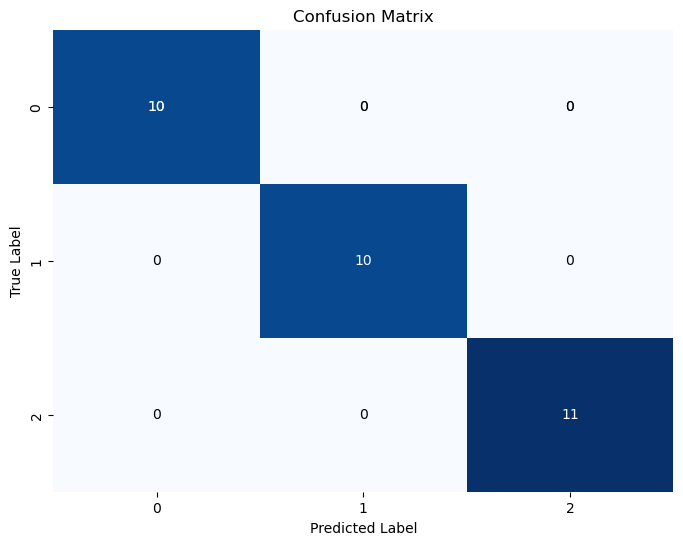

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        11

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

class_list = set(y_test)

# # Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_list, yticklabels=class_list)

for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[0])):
        if i == j:
            plt.text(j + 0.5, i + 0.5, str(conf_matrix[i, j]), ha='center', va='center', color='white')
        else:
            plt.text(j + 0.5, i + 0.5, str(conf_matrix[i, j]), ha='center', va='center', color='black')
            
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

In [54]:
# Display the mapping between class names and encoded numbers
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nClass Mapping:")
print(class_mapping)


Class Mapping:
{'bacterial_leaf_blight': 0, 'brown_spot': 1, 'rice_blast': 2}
